# Tag Classification with BiLSTM and CNN
This notebook is part of the source code of our ML project. It uses our self-trained Word2Vec (provided our drive) to train a BiLSTM model to predict professor tages based on user comments collected from ratemyprofessors.com. 

To run this notebook, first add [our drive](https://drive.google.com/drive/folders/15wGLUvjiGtFXMZ0XzpDYeSH1XEqWjUBB) as shortcut to your google drive or change the path below. 

For more information, please visit our [github repository](https://github.com/xuezzou/Rebuild-My-Professor/tree/main/Tags-Prediction).

In [16]:
import numpy as np
import pandas as pd

import os
import keras
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from keras.callbacks import Callback
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.preprocessing import text, sequence
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from gensim.models import Word2Vec, KeyedVectors 

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
EMBEDDING_FILE = '/content/drive/My Drive/Rebuild my Professor/Tags Prediction Notebooks/word2vec_model.bin'
data = pd.read_csv("/content/drive/My Drive/Rebuild my Professor/Tags Prediction Notebooks/train_test_data.csv", index_col=0)
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)

Data cleaning

In [3]:
train["rComments"].fillna("fillna")
test["rComments"].fillna("fillna")
X_train = train["rComments"].str.lower()
y_train = train[train.columns[2:]].values

X_test = test["rComments"].str.lower()

In [4]:
max_features=100000
maxlen=150
embed_size=32

In [5]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

## Word Embedding with Word2Vec

Tokenize words to numbers and then look up the embedding from the word2vec model

In [6]:
tok=text.Tokenizer(num_words=max_features,lower=True)
tok.fit_on_texts(list(X_train)+list(X_test))
X_train=tok.texts_to_sequences(X_train)
X_test=tok.texts_to_sequences(X_test)
x_train=sequence.pad_sequences(X_train,maxlen=maxlen)
x_test=sequence.pad_sequences(X_test,maxlen=maxlen)

In [7]:
embeddings_index = {}
from gensim.test.utils import datapath
word2vec = KeyedVectors.load_word2vec_format(datapath("/content/drive/My Drive/Rebuild my Professor/Tags Prediction Notebooks/word2vec_model.bin"), binary=True)
for word, embedding in word2vec.vocab.items():
  embeddings_index[word] = word2vec[word]

In [8]:
word_index = tok.word_index
#prepare embedding matrix
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## BiLSTM model

In [20]:
sequence_input = Input(shape=(maxlen, ))
x = Embedding(embedding_matrix.shape[0], embed_size, weights=[embedding_matrix],trainable = False)(sequence_input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 
preds = Dense(20, activation="sigmoid")(x)
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy'])

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 150, 32)      615168      input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 150, 32)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 150, 256)     124416      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [22]:
batch_size = 128
epochs = 6
X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=233)

In [23]:
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
history=model.fit(X_tra, y_tra, batch_size=batch_size, epochs=50, validation_data=(X_val, y_val),callbacks=[early_stopping_monitor])

Epoch 1/50
103/103 [==============================] - 114s 1s/step - loss: 0.4124 - accuracy: 0.0699 - val_loss: 0.3561 - val_accuracy: 0.1263
Epoch 2/50
103/103 [==============================] - 108s 1s/step - loss: 0.3556 - accuracy: 0.1290 - val_loss: 0.3469 - val_accuracy: 0.1577
Epoch 3/50
103/103 [==============================] - 108s 1s/step - loss: 0.3439 - accuracy: 0.1584 - val_loss: 0.3425 - val_accuracy: 0.1788
Epoch 4/50
103/103 [==============================] - 108s 1s/step - loss: 0.3400 - accuracy: 0.1683 - val_loss: 0.3401 - val_accuracy: 0.1788
Epoch 5/50
103/103 [==============================] - 108s 1s/step - loss: 0.3357 - accuracy: 0.1744 - val_loss: 0.3360 - val_accuracy: 0.1850
Epoch 6/50
103/103 [==============================] - 108s 1s/step - loss: 0.3316 - accuracy: 0.1879 - val_loss: 0.3368 - val_accuracy: 0.1891
Epoch 7/50
103/103 [==============================] - 108s 1s/step - loss: 0.3299 - accuracy: 0.1833 - val_loss: 0.3348 - val_accuracy: 0.2068

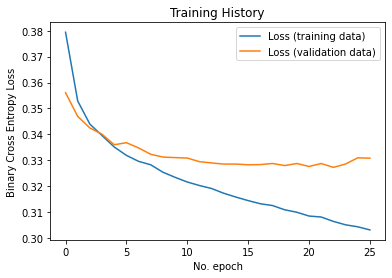

In [37]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Training History')
plt.ylabel('Binary Cross Entropy Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [42]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

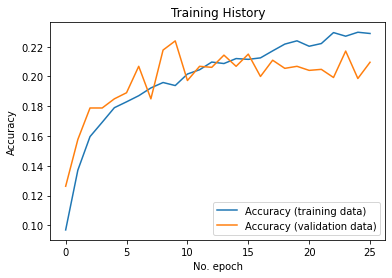

In [44]:
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

In [38]:
best_model='/content/drive/My Drive/Rebuild my Professor/Tags Prediction Notebooks/bilstm_best_model'
model.save(best_model)
model = keras.models.load_model(best_model)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Rebuild my Professor/Tags Prediction Notebooks/bilstm_best_model/assets


## Training results

In [40]:
predictions = model.predict(x_test,batch_size=1024,verbose=1)
results = np.where(predictions > 0.3, 1, 0)
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("{:<30} {:<20} {:<20} {:<20}".format("Category", "Precision", "Recall", "F1"))
resmetrics=np.zeros((20,3))
for i in range(20):
    predicted = results[:, i]
    actual = test.iloc[:, i+2]
    resmetrics[i]=[precision_score(actual, predicted, average='weighted'),recall_score(actual, predicted, average='weighted'),f1_score(actual, predicted, average='weighted')]
    print("{:<30} {:<20} {:<20} {:<20}".format(test.columns[i+2],resmetrics[i][0],resmetrics[i][1],resmetrics[i][2]))

4/4 [==============================] - 8s 2s/step
Category                       Precision            Recall               F1                  
Accessible outside class       0.8205793903115941   0.8533588203167668   0.8317761387719579  
Amazing lectures               0.8295500416263245   0.8091206990715456   0.8178768449921296  
Beware of pop quizzes          0.9553017189040272   0.9647733478973238   0.956704970515067   
Caring                         0.7576856293980659   0.7632441288913162   0.7602819899221218  
Clear grading criteria         0.8087982707580348   0.8492626979792464   0.8218120757335571  
EXTRA CREDIT                   0.9156836187096162   0.9292736209721464   0.9190449232588804  
Get ready to read              0.8173930220997285   0.7957400327689788   0.8050479673821931  
Gives good feedback            0.780675349487146    0.7812670671764064   0.78096966257796    
Graded by few things           0.873822603282749    0.8992353904969962   0.884944756126299   
Group proj

In [41]:
avgmetrics=np.mean(resmetrics,axis=0)
print("Averaged metrics:")
print("{:<20} {:<20} {:<20}".format("Precision", "Recall", "F1"))
print("{:<20} {:<20} {:<20}".format(avgmetrics[0], avgmetrics[1], avgmetrics[2]))


Averaged metrics:
Precision            Recall               F1                  
0.8411495118772322   0.8448252321135993   0.8410963585423017  


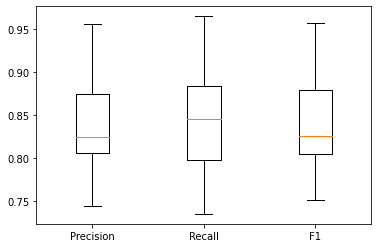

In [48]:
plt.boxplot(resmetrics)
plt.xticks([1, 2, 3], ['Precision', 'Recall', 'F1'])
plt.show()

### Sample model output result:

In [72]:
test.head()
i=12
print(test.iloc[i,1])
print(test.iloc[i,2:])
print(predictions[i])

Professor Greathead is very genuine in how he treats his students.  He wants them to not only succeed in his class but to be successful in their careers and lives as well.  He focuses on teaching applicable material. in I still recall many of the principles that he taught in his classes.  I highly recommend taking his classes! Great personality.
Accessible outside class       0
Amazing lectures               0
Beware of pop quizzes          0
Caring                         1
Clear grading criteria         0
EXTRA CREDIT                   0
Get ready to read              0
Gives good feedback            0
Graded by few things           0
Group projects                 0
Hilarious                      0
Inspirational                  1
Lecture heavy                  0
Lots of homework               0
Participation matters          0
Respected                      0
Skip class? You won't pass.    0
So many papers                 0
Test heavy                     0
Tough grader             

In [31]:
# test.iloc[:, 2:].shape #(3662, 20)

In [ ]:
# for i in range(5):
#   print(X_test[i])


# Understanding the correlation between tags

In this part we experienced with multiple methods to understand the correlation between the 20 tags (and see if there is one!)



Straight up correlation didn't give us too much information as they are all relatively small.

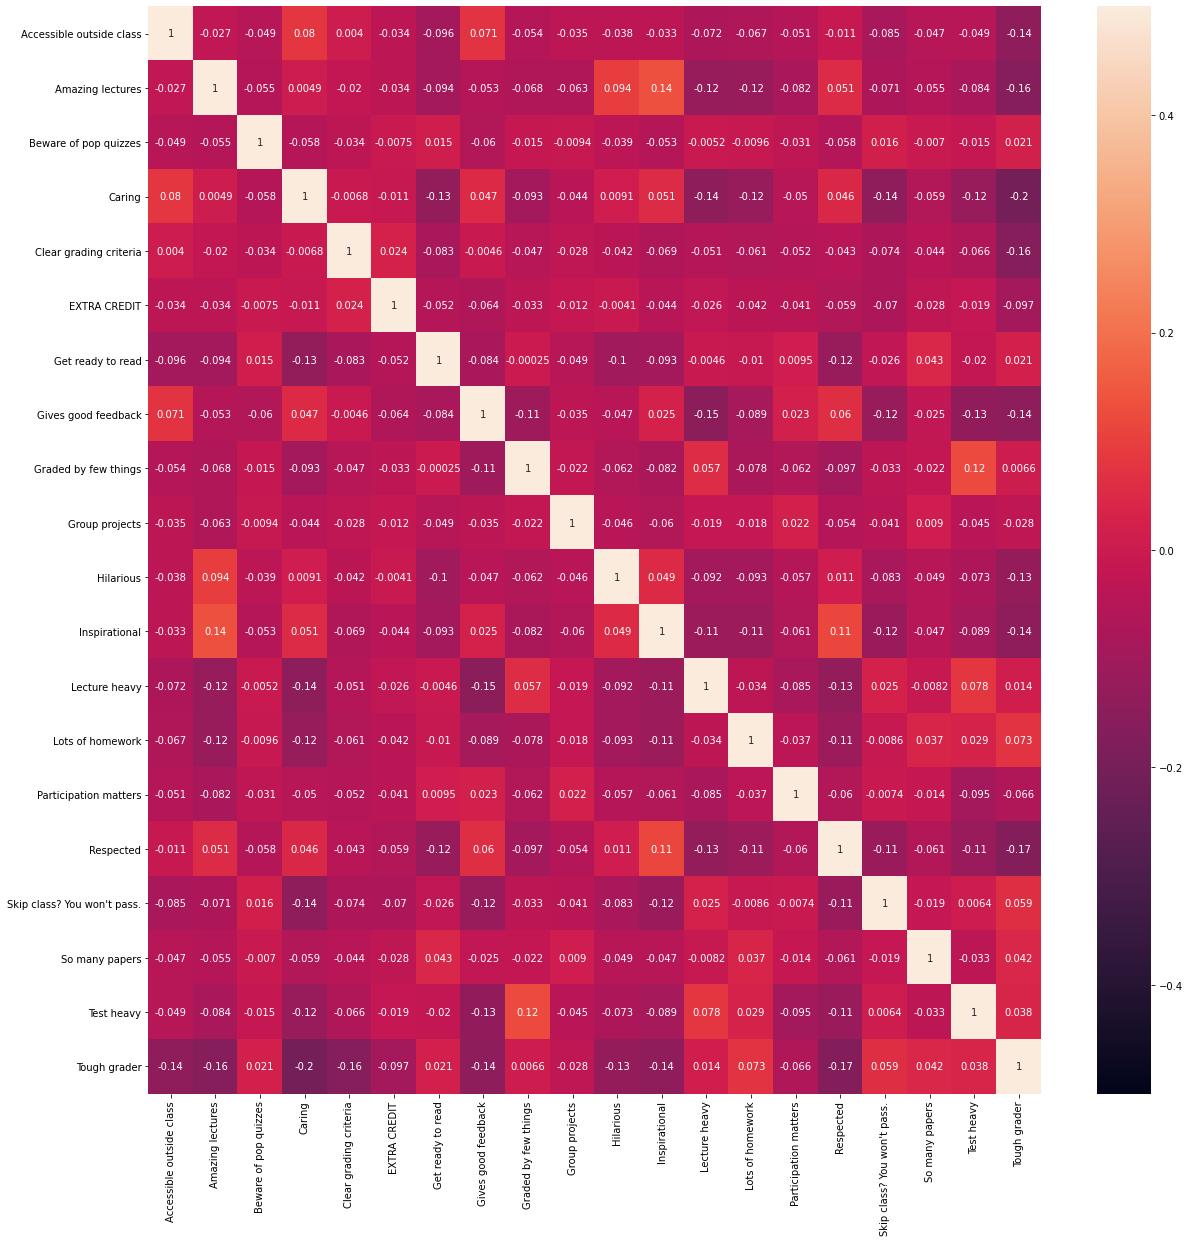

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
sns.heatmap(data.iloc[:, 2:].corr(), vmin=-0.5, vmax=0.5, annot=True)

Then we realized that understanding the correlation as conditionally probability would make more sense as some label classes are much smaller than the others

In [34]:
df_plot = data.iloc[:, 2:]
df_jaccard = pd.DataFrame(index=df_plot.columns, columns=df_plot.columns)
for column_1 in df_plot.columns:
  for column_2 in df_plot.columns:
    jaccard_idx = len(df_plot[(df_plot[column_1] == 1) & (df_plot[column_2] == 1)]) / len(df_plot[(df_plot[column_1] == 1)])
    df_jaccard.loc[column_1, column_2] = jaccard_idx

In [35]:
df_jaccard.fillna(0)

,Accessible outside class,Amazing lectures,Beware of pop quizzes,Caring,Clear grading criteria,EXTRA CREDIT,Get ready to read,Gives good feedback,Graded by few things,Group projects,Hilarious,Inspirational,Lecture heavy,Lots of homework,Participation matters,Respected,Skip class? You won't pass.,So many papers,Test heavy,Tough grader
Accessible outside class,1.000000,0.132044,0.014298,0.297309,0.140875,0.054247,0.078217,0.256939,0.047939,0.034062,0.089571,0.084525,0.076535,0.081161,0.096299,0.177881,0.099664,0.007149,0.058032,0.056770
Amazing lectures,0.108763,1.000000,0.014202,0.217180,0.121579,0.057153,0.090059,0.138552,0.043298,0.021476,0.193280,0.210599,0.041912,0.047108,0.075857,0.235885,0.121579,0.006235,0.038102,0.049186
Beware of pop quizzes,0.048227,0.058156,1.000000,0.093617,0.079433,0.068085,0.201418,0.069504,0.066667,0.043972,0.058156,0.028369,0.131915,0.124823,0.087943,0.075177,0.217021,0.021277,0.072340,0.239716
Caring,0.181655,0.161100,0.016958,1.000000,0.132837,0.072456,0.076567,0.221223,0.036999,0.035457,0.127698,0.142600,0.046763,0.058839,0.108684,0.224049,0.081706,0.008479,0.026978,0.044450
Clear grading criteria,0.133254,0.139618,0.022275,0.205648,1.000000,0.094670,0.094272,0.181384,0.054097,0.038584,0.087112,0.057279,0.096659,0.088703,0.096659,0.147176,0.113365,0.009149,0.046142,0.036197
EXTRA CREDIT,0.090084,0.115223,0.033520,0.196927,0.166201,1.000000,0.104749,0.100559,0.055168,0.045391,0.117318,0.063547,0.109637,0.090782,0.092877,0.110335,0.091480,0.011173,0.076117,0.065642
Get ready to read,0.058898,0.082331,0.044965,0.094364,0.075047,0.047498,1.000000,0.114313,0.087397,0.030082,0.050348,0.047498,0.137429,0.133629,0.149778,0.087397,0.163078,0.042115,0.082014,0.216593
Gives good feedback,0.179547,0.117543,0.014399,0.253012,0.133999,0.042316,0.106083,1.000000,0.022921,0.038202,0.089921,0.128416,0.032618,0.076403,0.158977,0.238613,0.086982,0.018513,0.012048,0.079342
Graded by few things,0.071117,0.077979,0.029320,0.089832,0.084841,0.049283,0.172177,0.048659,1.000000,0.038677,0.056145,0.028696,0.204616,0.053649,0.072988,0.066750,0.143481,0.015596,0.212726,0.207112
Group projects,0.081000,0.062000,0.031000,0.138000,0.097000,0.065000,0.095000,0.130000,0.062000,1.000000,0.060000,0.033000,0.114000,0.115000,0.174000,0.101000,0.119000,0.033000,0.040000,0.152000


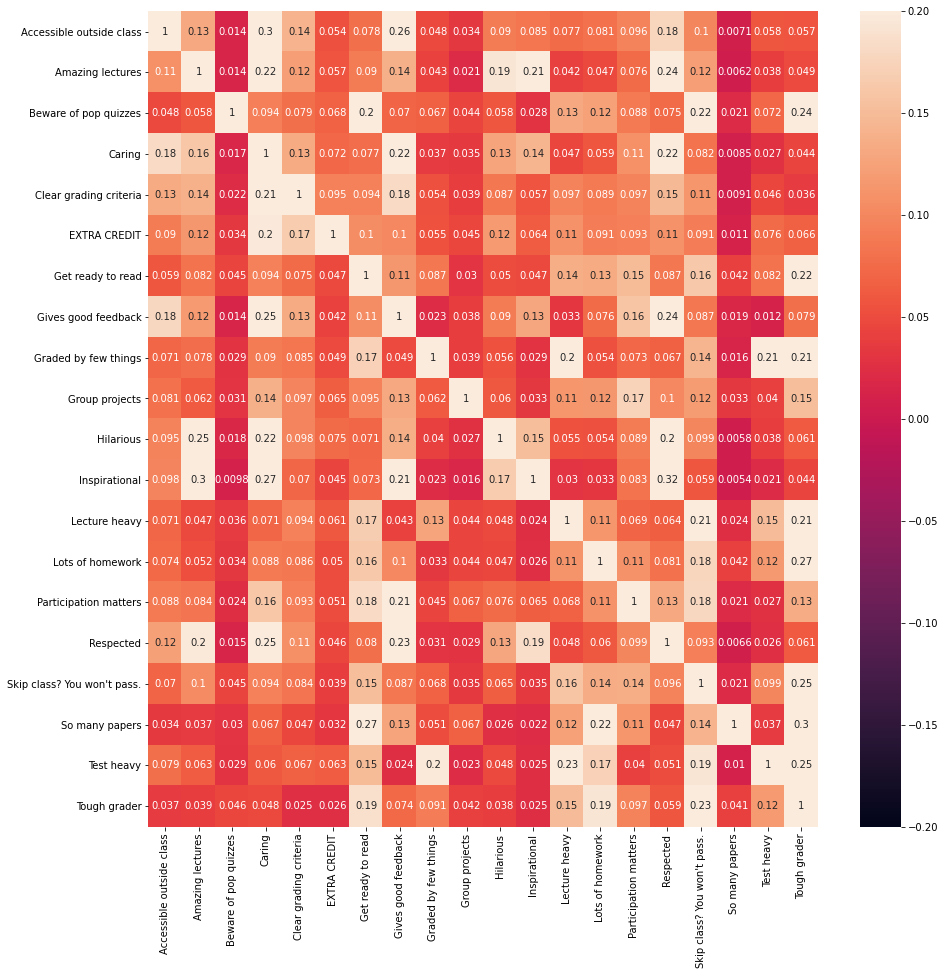

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
sns.heatmap(df_jaccard.fillna(0), vmin=-0.2, vmax=0.2, annot=True)